# Utilities

Overview:

1. Integrals.
3. Checkpointing.
4. Generating XDMF files.

**Keywords:** checkpointing, utilities, volume integrals, surface integrals, xdmf



## Integral Class

The `Integral` class constructs the volume integral

$$
F_{i}  =   \int_V \, f_i(\mathbf{x}) \, \mathrm{d} V  
$$

for some function $f_i$ (specified by a `Function` object), over some domain $V$ (specified by an `FeMesh` object), or the surface integral

$$
F_{i}  =   \oint_{\Gamma} \,  f_i(\mathbf{x})  \,  \mathrm{d}\Gamma  
$$

for some surface $\Gamma$ (specified via an `IndexSet` object on the mesh). 


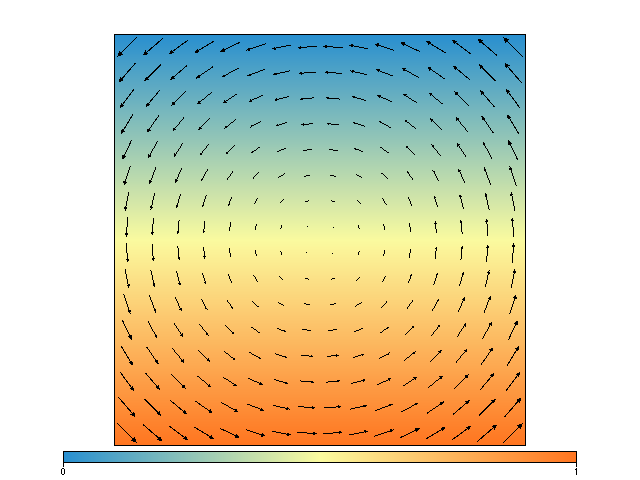

In [1]:
# setup some objects for demonstration
import underworld as uw
from underworld import function as fn
import glucifer
import math

# setup required objects
mesh             = uw.mesh.FeMesh_Cartesian(minCoord=(-1,-1), elementRes=(32,32))
temperatureField = mesh.add_variable( 1 )
velocityField    = mesh.add_variable( 2 )

# init
temperatureField.data[:,0] = -mesh.data[:,1]/2. + 0.5
velocityField.data[:,0]    =  -mesh.data[:,1]
velocityField.data[:,1]    =   mesh.data[:,0]

# viz
fig1 = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig1.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=0.1) )
fig1.append( glucifer.objects.Surface( mesh, temperatureField ) )
fig1.show()

In the following example, we will calculate a root mean square velocity defined as:
$$
v_{rms}  =  \sqrt{ \frac{ \int_V (\mathbf{v}.\mathbf{v}) \, \mathrm{d}V } {\int_V \, \mathrm{d}V} }
$$


The same result can be achieved through a number of paths. 

1. Call the `integrate()` method on a `Function` object.
2. Call the `integrate()` method on an `FeMesh` object.
3. Create an `Integral` class object, and call its `integrate()` method. 

Note that all three methods result in identical calculations. 

In [2]:
# note that the previous cell needs to have been executed before this one. 
# define required function
vdotv = fn.math.dot( velocityField, velocityField )

# evaluate area (domain) integrals on the function
v2sum =  mesh.integrate( vdotv ) # ... option 2
volume = mesh.integrate( 1.0 )

# finally, calculate RMS
v_rms  = math.sqrt( v2sum[0] )/volume[0]
print('RMS velocity = {0:.3f}'.format(v_rms))

# option 3
# create integral objects, passing in functions
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=vdotv )
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )

# evaluate integrals
v2sum  = v2sum_integral.evaluate()
volume = volume_integral.evaluate()

# finally, calculate RMS
v_rms  = math.sqrt( v2sum[0] )/volume[0]
print('RMS velocity = {0:.3f}'.format(v_rms))

RMS velocity = 0.408
RMS velocity = 0.408


To evaluate an integral over a subdomain the ``fn.branching.conditional`` class may be useful:

Area from integral = 3.14559221e+00



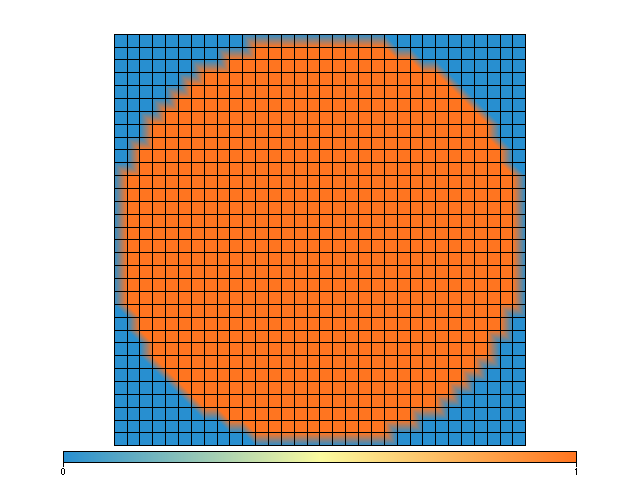

In [3]:
import underworld as uw
from underworld import function as fn
import glucifer
mesh = uw.mesh.FeMesh_Cartesian(minCoord=(-1,-1), elementRes=(32,32))

# create circle function
radius = 1.
coord    = fn.coord() 
fn_sphere = fn.math.dot( coord, coord ) < radius**2

# setup a function that is 1 if the coordinates, are inside the circle, and zero otherwise.
conditions     = [ ( fn_sphere , 1.0), 
                   ( True      , 0.0) ]
kernelFunction = fn.branching.conditional( conditions )

# create and evaluate integral
volume = mesh.integrate( kernelFunction )
print('Area from integral = {0:6.8e}'.format(volume[0]))
fig = glucifer.Figure()
fig.append( glucifer.objects.Mesh(mesh) )
fig.append( glucifer.objects.Surface(mesh, kernelFunction))
fig.show()

In the following example, we will calculate the Nusselt number defined by

$$
Nu = -h \frac{ \oint_{\Gamma_{t}} \partial_z T (\mathbf{x}) \, \mathrm{d}\Gamma}{ \int_{\Gamma_{b}} T (\mathbf{x}) \,  \mathrm{d}\Gamma}
$$

where $h$ is the height of the domain, and $\Gamma_t$ and $\Gamma_b$ are the top and bottom surfaces respectively.

NB. Surface integrals must still be implemented using the old implementation mesh of creating a `uw.utils.Integral` object


In [4]:
import underworld as uw
from underworld import function as fn
import glucifer
import math
mesh = uw.mesh.FeMesh_Cartesian(minCoord=(-1,-1), elementRes=(32,32))
temperatureField = mesh.add_variable( 1 )
temperatureField.data[:,0] = -mesh.data[:,1]/2. + 0.5


nuTop    = uw.utils.Integral( fn=temperatureField.fn_gradient[1], 
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])

nuBottom = uw.utils.Integral( fn=temperatureField,               
                              mesh=mesh, integrationType='Surface', 
                              surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

nu = - nuTop.evaluate()[0]/nuBottom.evaluate()[0]
print('Nusselt number = {0:.6f}'.format(nu))

Nusselt number = 0.500000


## Checkpointing 

Checkpointing is the process of saving sufficient data to facilitate restarting your simulations at a later stage. Note that we do not provide explicit checkpointing functionality, but instead provide the tools required for the loading and saving of heavy data. Which data items are required for restart will depend on the systems you have used and how you have constructed your models.

The following Underworld data structures have load/save functionality: 
 * `SwarmVariables` 
 * `Swarm`
 * `MeshVariables`
 * `Mesh`

All files are saved in HDF5 format.

*Note*: When saving a `SwarmVariable`, if you wish to reload the `SwarmVariable` data at a later stage, you must also save the `Swarm` for the corresponding state (generally, the same timestep). This requirement is due to the population control mechanisms swarms generally used for swarms, and also due to particles crossing process boundaries. When you come to reload the `Swarm` and `SwarmVariable`, you must load the `Swarm` **first**. Note again that the `Swarm` and `SwarmVariable` must be of corresponding state for successful reload.


### Swarms and Swarm Variables

Below a `Swarm` and a `SwarmVariable`, are created and saved to disk, then a new swarm loads the data from disk.


* Save the swarm data to disk using the `save()` method on the `Swarm` and `SwarmVariable` objects.  
   Note the handle object that is returned from the `save()` method. This is currently used for `xdmf()` operation, see below.
* Load the swarm data from disk using the `load()` method on the `Swarm` and `SwarmVariable` objects


In [5]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np
mesh = uw.mesh.FeMesh_Cartesian(minCoord=(-1,-1), elementRes=(32,32))
swarm1    = uw.swarm.Swarm(mesh)
swarm1var = swarm1.add_variable(dataType='int', count=1)
layout    = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm1,particlesPerCell=5)
swarm1.populate_using_layout(layout)

# set random data to save
swarm1var.data[:,0] = np.random.rand(len(swarm1var.data))

ignore = swarm1.save('swarm.h5')
ignore = swarm1var.save('swarmvar.h5')

# new swarm
swarm2    = uw.swarm.Swarm(mesh)
swarm2var = swarm2.add_variable(dataType='int', count=1)
swarm2.load('swarm.h5')
swarm2var.load('swarmvar.h5')

if not np.allclose( swarm2var.data[:], swarm1var.data[:] ):
    raise RuntimeError("Something went wrong, the swarms are not identical.")
if not np.allclose( swarm2.particleCoordinates.data[:], swarm1.particleCoordinates.data[:]):
    raise RuntimeError("Something went wrong, the swarms variables are not identical.")
    
if uw.mpi.rank == 0:
    import os
    os.remove('swarm.h5')
    os.remove('swarmvar.h5')

### Mesh and Mesh Variables

The `MeshVariable` object behaves similarly to `SwarmVariable` object with the `save()` and `load()` functionality.

In [6]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np
mesh = uw.mesh.FeMesh_Cartesian(minCoord=(-1,-1), elementRes=(32,32))

# create var and set random data
meshvar = mesh.add_variable(1)
meshvar.data[:,0] = np.random.rand(len(meshvar.data))

ignore = mesh.save('mesh.h5')
ignore = meshvar.save('meshvar.h5')

newvar = mesh.add_variable(1)
newvar.load('meshvar.h5')

# ensure expected result
if not np.allclose( newvar.data, meshvar.data ):
    raise RuntimeError("Something went wrong, the mesh variables are not identical.")

if uw.mpi.rank == 0:
    import os
    os.remove('mesh.h5')
    os.remove('meshvar.h5')

Writing to XDMF files
-----
The `XDMF` file specifies how your model *data* (`MeshVariable` and/or `SwarmVariable` objects) and *geometry* (`Mesh` and/or `Swarm` objects) is layed out within the HDF5 files you have saved to disk. It is a light (or sidecar) file written in XML which accompanies your heavy HDF5 files to allow applications such as [ParaView](http://www.paraview.org/) to visualise your models.

In Underworld, whenever you call a `save()` operation, we return *handler* objects which specify the information required to create the `XDMF` files. If you do not wish to create XDMF files, you can ignore these handler objects. Otherwise, you need to retain them, and then pass them into the `xdmf()` methods so that it has the information it requires. Note that any object that has a `save()` method, will also have an `xdmf()` method.

We generate XDMF files in the following example. We will also print an XDMF file, but note that you generally should not need to manually view or modify these files. For details on writing XDMF files in a dynamical context, please see the Rayleigh-Taylor example.

In [30]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np

# mesh
mesh = uw.mesh.FeMesh_Cartesian(elementType='Q1', elementRes=(4,4))               # 16 elements total
meshvar = mesh.add_variable(1)                                                    # 25 meshvar nodes total
xdmf_info_mesh    = mesh.save('mesh.h5')
xdmf_info_meshvar = meshvar.save('meshvar.h5')

# swarm
swarm1    = uw.swarm.Swarm(mesh)
swarm1var = swarm1.add_variable(dataType='int', count=1)
layout    = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm1,particlesPerCell=5)  # 80 particles total
swarm1.populate_using_layout(layout)
xdmf_info_swarm    = swarm1.save('swarm.h5')
xdmf_info_swarmvar = swarm1var.save('swarmvar.h5')

# xdmf
meshvar.xdmf('meshvar.xdmf', xdmf_info_meshvar, "MyField", xdmf_info_mesh, "TheMesh", modeltime=0.0)
swarm1var.xdmf('swarmvar.xdmf', xdmf_info_swarmvar, "SwarmVariable", xdmf_info_swarm, "TheSwarm", modeltime=0.1)

# print an xdmf file
# printfile = 'meshvar.xdmf'
printfile = 'swarmvar.xdmf'
with open(printfile, 'r') as f:
    print(f.read())

if uw.mpi.rank == 0:
    import os
    os.remove('mesh.h5')
    os.remove('meshvar.h5')
    os.remove('swarm.h5')
    os.remove('swarmvar.h5')
    os.remove('meshvar.xdmf')
    os.remove('swarmvar.xdmf')

<?xml version="1.0" ?>
<Xdmf xmlns:xi="http://www.w3.org/2001/XInclude" Version="2.0">
<Domain>
<Grid Name="TheSwarm" GridType="Uniform">

	<Time Value="0.1" />

	<Topology Type="POLYVERTEX" NodesPerElement="80"> </Topology>
		<Geometry Type="XY">
			<DataItem Format="HDF" NumberType="Float" Precision="8" Dimensions="80 2">swarm.h5:/data</DataItem>
		</Geometry>
	<Attribute Type="Scalar" Center="Node" Name="SwarmVariable">
			<DataItem Format="HDF" NumberType="Float" Precision="8" Dimensions="80 1">swarmvar.h5:/data</DataItem>
	</Attribute>
</Grid>
</Domain>
</Xdmf>

